In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
)
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from scikeras.wrappers import KerasRegressor
import itertools
from sklearn.model_selection import cross_val_score
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Read CSV
file_path = "Data.csv"
df = pd.read_csv(file_path)

In [3]:
print(df.head())

         fW   current           ind      Rd            Cs     Rs  \
0  0.000003  0.000800  3.000000e-09   625.0  6.670000e-14  700.0   
1  0.000003  0.000851  2.180000e-09   983.4  1.320000e-13  786.2   
2  0.000005  0.002167  1.190000e-09   183.8  3.590000e-14  709.9   
3  0.000003  0.001467  9.630000e-10  1080.0  4.100000e-13  720.8   
4  0.000007  0.001899  1.720000e-09  1182.0  1.220000e-13  467.2   

   Stage 1 Region  channel 0.1G attenuation  channel 3.5G attenuation  \
0               1                  -0.01972                    -6.577   
1               0                  -0.01970                    -6.581   
2               1                  -0.01972                    -6.579   
3               0                  -0.01969                    -6.582   
4               0                  -0.01960                    -6.595   

   channel 7G attenuation  ...  stage 2 0.1G attenuation  \
0                  -9.067  ...                    -1.492   
1                  -9.077  ...  

In [4]:
target_cols = [
    "stage 1 3.5G attenuation",
    "stage 2 3.5G attenuation",
    "stage 1 7G attenuation",
    "stage 2 7G attenuation",
    "stage 1 14G attenuation",
    "stage 2 14G attenuation",
    "stage 1 28G attenuation",
    "stage 2 28G attenuation",
]

In [5]:
feature_columns = [col for col in df.columns if col not in target_cols]

In [6]:
# Split features and targets
X = df[feature_columns].copy()
y = df[target_cols].copy()

In [7]:
print(f"\nFeature columns ({len(feature_columns)}):", feature_columns)
print(f"Target columns ({len(target_cols)}):", target_cols)
print(f"Features shape: {X.shape}")
print(f"Targets shape: {y.shape}")


Feature columns (15): ['fW', 'current', 'ind', 'Rd', 'Cs', 'Rs', 'Stage 1 Region', 'channel 0.1G attenuation', 'channel 3.5G attenuation', 'channel 7G attenuation', 'channel 14G attenuation', 'channel 28G attenuation', 'stage 1 0.1G attenuation', 'stage 2 0.1G attenuation', 'Hard Constraint of 2 on 0.1G Status']
Target columns (8): ['stage 1 3.5G attenuation', 'stage 2 3.5G attenuation', 'stage 1 7G attenuation', 'stage 2 7G attenuation', 'stage 1 14G attenuation', 'stage 2 14G attenuation', 'stage 1 28G attenuation', 'stage 2 28G attenuation']
Features shape: (5001, 15)
Targets shape: (5001, 8)


In [8]:
numerical_features = [
    "fW",
    "current",
    "ind",
    "Rd",
    "Cs",
    "Rs",
    "channel 0.1G attenuation",
    "channel 3.5G attenuation",
    "channel 7G attenuation",
    "channel 14G attenuation",
    "channel 28G attenuation",
    "stage 1 0.1G attenuation",
    "stage 2 0.1G attenuation",
]

In [9]:
categorical_features = [
    "Stage 1 Region",
    "Hard Constraint of 2 on 0.1G Status",
]  # Assuming this is the only remaining categorical to encode

In [10]:
# Ensure only existing columns are included
numerical_features = [f for f in numerical_features if f in X.columns]
categorical_features = [f for f in categorical_features if f in X.columns]

In [11]:
print(numerical_features)

['fW', 'current', 'ind', 'Rd', 'Cs', 'Rs', 'channel 0.1G attenuation', 'channel 3.5G attenuation', 'channel 7G attenuation', 'channel 14G attenuation', 'channel 28G attenuation', 'stage 1 0.1G attenuation', 'stage 2 0.1G attenuation']


In [12]:
print(categorical_features)

['Stage 1 Region', 'Hard Constraint of 2 on 0.1G Status']


In [13]:
# Check for missing features
all_defined_features = set(numerical_features + categorical_features)
actual_features = set(X.columns)
missing_features = actual_features - all_defined_features
if missing_features:
    print(
        f"\nWarning: These features are not classified as numerical or categorical: {missing_features}"
    )

## Preprocessing


In [14]:
# --- Custom IQR Outlier Capper ---
class IQROutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_bound_mult=1.5, upper_bound_mult=1.5):
        self.lower_bound_mult = lower_bound_mult
        self.upper_bound_mult = upper_bound_mult
        self.lower_bounds_ = {}
        self.upper_bounds_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X

        for col in X.columns:
            if pd.api.types.is_numeric_dtype(X[col]) and not X[col].isnull().all():
                Q1 = X[col].quantile(0.25)
                Q3 = X[col].quantile(0.75)
                IQR = Q3 - Q1
                self.lower_bounds_[col] = Q1 - (IQR * self.lower_bound_mult)
                self.upper_bounds_[col] = Q3 + (IQR * self.upper_bound_mult)
            else:
                self.lower_bounds_[col] = -np.inf
                self.upper_bounds_[col] = np.inf
        return self

    def transform(self, X):
        X = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        X_copy = X.copy()

        for col in X_copy.columns:
            if (
                col in self.lower_bounds_
                and pd.api.types.is_numeric_dtype(X_copy[col])
                and self.lower_bounds_[col] != -np.inf
                and self.upper_bounds_[col] != np.inf
            ):
                X_copy[col] = X_copy[col].clip(
                    lower=self.lower_bounds_[col], upper=self.upper_bounds_[col]
                )
        return X_copy

In [15]:
# --- Preprocessing Pipeline ---
# Numerical preprocessing
numerical_transformer = Pipeline(
    steps=[
        ("outlier_capper", IQROutlierCapper()),
        ("imputer", SimpleImputer(strategy="median")),  # Using median for robustness
        ("scaler", RobustScaler()),
    ]
)

# Categorical preprocessing
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

# Combined preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop",  # Drop any remaining columns instead of passthrough
)

print("\n--- Preprocessing Pipeline Created ---")
print("Numerical transformer steps:", numerical_transformer.steps)
print("Categorical transformer steps:", categorical_transformer.steps)


--- Preprocessing Pipeline Created ---
Numerical transformer steps: [('outlier_capper', IQROutlierCapper()), ('imputer', SimpleImputer(strategy='median')), ('scaler', RobustScaler())]
Categorical transformer steps: [('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=X["Hard Constraint of 2 on 0.1G Status"],
)

In [17]:
print(f"\nTrain/Test Split Complete:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Train/Test Split Complete:
X_train shape: (3500, 15)
X_test shape: (1501, 15)
y_train shape: (3500, 8)
y_test shape: (1501, 8)


In [18]:
print("\n--- Applying Preprocessing ---")

# Fit on training data and transform both train and test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"X_test_processed shape: {X_test_processed.shape}")


--- Applying Preprocessing ---
X_train_processed shape: (3500, 17)
X_test_processed shape: (1501, 17)


In [19]:
try:
    feature_names = preprocessor.get_feature_names_out()
    print(f"Successfully retrieved {len(feature_names)} feature names")
except AttributeError:
    # Fallback for older scikit-learn versions
    print("Using fallback method for feature names...")

    # Get numerical feature names (same as input)
    num_feature_names = numerical_features

    # Get categorical feature names
    cat_feature_names = []
    if categorical_features:
        onehot_encoder = preprocessor.named_transformers_["cat"].named_steps["onehot"]
        cat_feature_names = onehot_encoder.get_feature_names_out(
            categorical_features
        ).tolist()

    feature_names = num_feature_names + cat_feature_names

print(f"Final feature names ({len(feature_names)}):", feature_names)

Using fallback method for feature names...
Final feature names (17): ['fW', 'current', 'ind', 'Rd', 'Cs', 'Rs', 'channel 0.1G attenuation', 'channel 3.5G attenuation', 'channel 7G attenuation', 'channel 14G attenuation', 'channel 28G attenuation', 'stage 1 0.1G attenuation', 'stage 2 0.1G attenuation', 'Stage 1 Region_0', 'Stage 1 Region_1', 'Hard Constraint of 2 on 0.1G Status_0', 'Hard Constraint of 2 on 0.1G Status_1']


In [20]:
# Convert to DataFrames for easier handling
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

In [21]:
print("\n--- Preprocessing Complete ---")
print(f"Final training features shape: {X_train_df.shape}")
print(f"Final test features shape: {X_test_df.shape}")


--- Preprocessing Complete ---
Final training features shape: (3500, 17)
Final test features shape: (1501, 17)


## Model Building and Evaluation


In [22]:
# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    """Evaluate multi-output regression model"""
    results = {}

    # Overall metrics
    overall_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    overall_mae = mean_absolute_error(y_true, y_pred)
    overall_r2 = r2_score(y_true, y_pred)

    results["overall"] = {"RMSE": overall_rmse, "MAE": overall_mae, "R²": overall_r2}

    # Per-target metrics
    results["per_target"] = {}
    for i, col in enumerate(y_true.columns):
        rmse = np.sqrt(mean_squared_error(y_true.iloc[:, i], y_pred[:, i]))
        mae = mean_absolute_error(y_true.iloc[:, i], y_pred[:, i])
        r2 = r2_score(y_true.iloc[:, i], y_pred[:, i])

        # MAPE calculation (avoiding division by zero)
        y_true_col = y_true.iloc[:, i]
        y_pred_col = y_pred[:, i]
        mape = (
            np.mean(
                np.abs(
                    (y_true_col - y_pred_col) / np.where(y_true_col != 0, y_true_col, 1)
                )
            )
            * 100
        )

        results["per_target"][col] = {"RMSE": rmse, "MAE": mae, "R²": r2, "MAPE": mape}

    return results

In [23]:
def print_results(results, model_name):
    """Print evaluation results"""
    print(f"\n{'='*60}")
    print(f"{model_name} RESULTS")
    print(f"{'='*60}")

    print(f"\nOverall Performance:")
    print(f"RMSE: {results['overall']['RMSE']:.4f}")
    print(f"MAE:  {results['overall']['MAE']:.4f}")
    print(f"R²:   {results['overall']['R²']:.4f}")

    print(f"\nPer-Target Performance:")
    for target, metrics in results["per_target"].items():
        print(f"{target}:")
        print(f"  RMSE: {metrics['RMSE']:.4f}")
        print(f"  MAE:  {metrics['MAE']:.4f}")
        print(f"  R²:   {metrics['R²']:.4f}")
        print(f"  MAPE: {metrics['MAPE']:.2f}%")

In [24]:
# Store all results
all_results = {}

### 1. XGBoost


In [25]:
# XGBoost model
xgb_model = MultiOutputRegressor(
    XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=1,
        # tree_method="gpu_hist",
        # predictor="gpu_predictor",
    )
)

In [26]:
# xgb_param_grid = {
#     "estimator__n_estimators": [100, 200, 300],
#     "estimator__learning_rate": [0.01, 0.1, 0.2],
#     "estimator__max_depth": [3, 5, 7],
#     "estimator__min_child_weight": [1, 3, 5],
#     "estimator__gamma": [0, 0.1, 0.2],
#     "estimator__subsample": [0.8, 0.9, 1.0],
#     "estimator__colsample_bytree": [0.8, 0.9, 1.0],
#     "estimator__reg_alpha": [0, 0.01, 0.1],
#     "estimator__reg_lambda": [1, 1.3, 1.5],
# }

xgb_param_grid = {
    "estimator__subsample": [0.8],
    "estimator__reg_lambda": [1.3],
    "estimator__reg_alpha": [0.01],
    "estimator__n_estimators": [300],
    "estimator__min_child_weight": [5],
    "estimator__max_depth": [5],
    "estimator__learning_rate": [0.1],
    "estimator__gamma": [0.2],
    "estimator__colsample_bytree": [0.9],
}

# {
#     "estimator__subsample": 0.8,
#     "estimator__reg_lambda": 1.3,
#     "estimator__reg_alpha": 0.01,
#     "estimator__n_estimators": 300,
#     "estimator__min_child_weight": 5,
#     "estimator__max_depth": 5,
#     "estimator__learning_rate": 0.1,
#     "estimator__gamma": 0,
#     "estimator__colsample_bytree": 0.9,
# }

In [27]:
# # GridSearchCV for XGBoost
# xgb_grid = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=xgb_param_grid,
#     cv=2,
#     scoring="neg_mean_squared_error",
#     verbose=1,
#     n_jobs=-1,
# )

In [28]:
# RandomizedSearchCV for XGBoost
xgb_grid = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=1000,
    cv=5,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=-1,
)

In [29]:
xgb_grid.fit(X_train_df, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,estimator,"MultiOutputRe...ee=None, ...))"
,param_distributions,"{'estimator__colsample_bytree': [0.9], 'estimator__gamma': [0.2], 'estimator__learning_rate': [0.1], 'estimator__max_depth': [5], ...}"
,n_iter,1000
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [30]:
# Best XGBoost model
best_xgb = xgb_grid.best_estimator_
xgb_pred = best_xgb.predict(X_test_df)

In [31]:
feature_importances = best_xgb.estimators_[0].feature_importances_

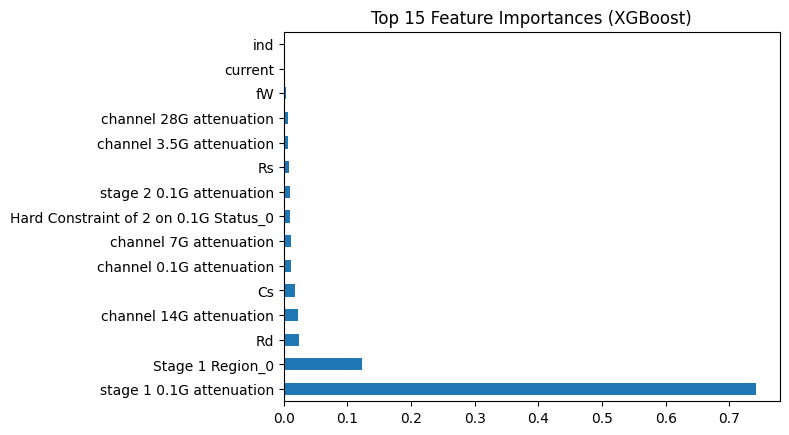

In [32]:
# Create a plot
feat_importances = pd.Series(feature_importances, index=feature_names)
feat_importances.nlargest(15).plot(kind="barh")
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()

In [33]:
xgb_results = evaluate_model(y_test, xgb_pred, "XGBoost")
all_results["XGBoost"] = xgb_results
print_results(xgb_results, "XGBoost")


XGBoost RESULTS

Overall Performance:
RMSE: 1.3299
MAE:  0.9096
R²:   0.9946

Per-Target Performance:
stage 1 3.5G attenuation:
  RMSE: 1.3992
  MAE:  0.9372
  R²:   0.9948
  MAPE: 48.85%
stage 2 3.5G attenuation:
  RMSE: 1.6941
  MAE:  1.1917
  R²:   0.9903
  MAPE: 18.93%
stage 1 7G attenuation:
  RMSE: 1.1813
  MAE:  0.8197
  R²:   0.9962
  MAPE: 5.38%
stage 2 7G attenuation:
  RMSE: 1.4599
  MAE:  1.0460
  R²:   0.9929
  MAPE: 59.79%
stage 1 14G attenuation:
  RMSE: 1.0416
  MAE:  0.7177
  R²:   0.9969
  MAPE: 3.10%
stage 2 14G attenuation:
  RMSE: 1.3709
  MAE:  0.9694
  R²:   0.9941
  MAPE: 10.62%
stage 1 28G attenuation:
  RMSE: 0.9686
  MAE:  0.6572
  R²:   0.9971
  MAPE: 2.16%
stage 2 28G attenuation:
  RMSE: 1.3751
  MAE:  0.9377
  R²:   0.9948
  MAPE: 9.82%


In [34]:
print(f"\nBest XGBoost Parameters: {xgb_grid.best_params_}")
print(f"Best XGBoost CV Score: {-xgb_grid.best_score_:.4f}")


Best XGBoost Parameters: {'estimator__subsample': 0.8, 'estimator__reg_lambda': 1.3, 'estimator__reg_alpha': 0.01, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 5, 'estimator__max_depth': 5, 'estimator__learning_rate': 0.1, 'estimator__gamma': 0.2, 'estimator__colsample_bytree': 0.9}
Best XGBoost CV Score: 2.3912


Best XGBoost Parameters: {'estimator__subsample': 0.8, 'estimator__reg_lambda': 1.5, 'estimator__reg_alpha': 0.1, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 3, 'estimator__max_depth': 5, 'estimator__learning_rate': 0.2, 'estimator__gamma': 0, 'estimator__colsample_bytree': 1.0}
Best XGBoost CV Score: 2.6115

Best XGboost Parameters: {'estimator__subsample': 0.8, 'estimator__reg_lambda': 1.3, 'estimator__reg_alpha': 0.01, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 5, 'estimator__max_depth': 5, 'estimator__learning_rate': 0.1, 'estimator__gamma': 0, 'estimator__colsample_bytree': 0.9}
Best XGboost CV Score: 2.3660

### LightGBM


In [35]:
lgb_model = MultiOutputRegressor(
    LGBMRegressor(objective="regression", random_state=42, n_jobs=-1)
)

In [36]:
# LightGBM hyperparameter grid
# lgb_param_grid = {
#     "estimator__n_estimators": [100, 300],
#     "estimator__learning_rate": [0.01, 0.1, 0.2],
#     "estimator__max_depth": [3, 5, 7],
#     "estimator__min_child_samples": [10, 20, 30],
#     "estimator__min_child_weight": [1, 3, 5],
#     "estimator__subsample": [0.8, 0.9, 1.0],
#     "estimator__colsample_bytree": [0.8, 0.9, 1.0],
#     "estimator__reg_alpha": [0, 0.01, 0.1],
#     "estimator__reg_lambda": [0, 0.01, 0.1],
# }

lgb_param_grid = {
    "estimator__subsample": [1.0],
    "estimator__reg_lambda": [0.01],
    "estimator__reg_alpha": [0.1],
    "estimator__n_estimators": [300],
    "estimator__min_child_weight": [3],
    "estimator__min_child_samples": [10],
    "estimator__max_depth": [5],
    "estimator__learning_rate": [0.2],
    "estimator__colsample_bytree": [1.0],
}

In [37]:
# lgb_grid = GridSearchCV(
#     estimator=lgb_model,
#     param_grid=lgb_param_grid,
#     cv=2,
#     scoring="neg_mean_squared_error",
#     verbose=1,
#     n_jobs=-1,
# )

In [38]:
lgb_grid = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=lgb_param_grid,
    n_iter=10,
    cv=5,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=1,
)

In [39]:
lgb_grid.fit(X_train_df, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2189
[LightGBM] [Info] Number of data points in the train set: 2800, number of used features: 17
[LightGBM] [Info] Start training from score -25.891020
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

,estimator,MultiOutputRe...dom_state=42))
,param_distributions,"{'estimator__colsample_bytree': [1.0], 'estimator__learning_rate': [0.2], 'estimator__max_depth': [5], 'estimator__min_child_samples': [10], ...}"
,n_iter,10
,scoring,'neg_mean_squared_error'
,n_jobs,1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [40]:
# Best LightGBM model
best_lgb = lgb_grid.best_estimator_
lgb_pred = best_lgb.predict(X_test_df)

In [41]:
lgb_results = evaluate_model(y_test, lgb_pred, "LightGBM")
print(lgb_results)

all_results["LightGBM"] = lgb_results

print_results(lgb_results, "LightGBM")

{'overall': {'RMSE': np.float64(1.4287285787431936), 'MAE': 0.9639574593193156, 'R²': 0.9937909140998642}, 'per_target': {'stage 1 3.5G attenuation': {'RMSE': np.float64(1.4369856748666654), 'MAE': 0.956753206801024, 'R²': 0.9944693331710782, 'MAPE': np.float64(39.21289182208429)}, 'stage 2 3.5G attenuation': {'RMSE': np.float64(1.7709034865693691), 'MAE': 1.2446023643603874, 'R²': 0.9893988198274739, 'MAPE': np.float64(23.146586491438345)}, 'stage 1 7G attenuation': {'RMSE': np.float64(1.2354890371292753), 'MAE': 0.8541929275499962, 'R²': 0.9958096534176364, 'MAPE': np.float64(5.675723597712133)}, 'stage 2 7G attenuation': {'RMSE': np.float64(1.5977885024941336), 'MAE': 1.0940012645952488, 'R²': 0.9914559860434166, 'MAPE': np.float64(58.56561113017884)}, 'stage 1 14G attenuation': {'RMSE': np.float64(1.1279406875309343), 'MAE': 0.7526409392559826, 'R²': 0.9963197081681558, 'MAPE': np.float64(3.2240091158052473)}, 'stage 2 14G attenuation': {'RMSE': np.float64(1.5381762615323498), 'MAE

In [42]:
print(f"\nBest LightGBM Parameters: {lgb_grid.best_params_}")
print(f"Best LightGBM CV Score: {-lgb_grid.best_score_:.4f}")


Best LightGBM Parameters: {'estimator__subsample': 1.0, 'estimator__reg_lambda': 0.01, 'estimator__reg_alpha': 0.1, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 3, 'estimator__min_child_samples': 10, 'estimator__max_depth': 5, 'estimator__learning_rate': 0.2, 'estimator__colsample_bytree': 1.0}
Best LightGBM CV Score: 2.7707


Best LightGBM Parameters: {'estimator__subsample': 1.0, 'estimator__reg_lambda': 0.01, 'estimator__reg_alpha': 0.1, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 3, 'estimator__min_child_samples': 10, 'estimator__max_depth': 5, 'estimator__learning_rate': 0.2, 'estimator__colsample_bytree': 1.0}
Best LightGBM CV Score: 2.7707

Best LightGBM Parameters: {'estimator__subsample': 0.8, 'estimator__reg_lambda': 0, 'estimator__reg_alpha': 0.01, 'estimator__n_estimators': 300, 'estimator__min_child_weight': 1, 'estimator__min_child_samples': 10, 'estimator__max_depth': 7, 'estimator__learning_rate': 0.1, 'estimator__colsample_bytree': 0.9}
Best LightGBM CV Score: 2.4571

### DNN


In [43]:
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

In [44]:
# Create MLP model
mlp_model = MultiOutputRegressor(
    MLPRegressor(
        hidden_layer_sizes=(128, 64, 32),
        activation="relu",
        solver="adam",
        alpha=0.001,
        learning_rate_init=0.001,
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
        random_state=42,
    )
)

In [ ]:
# Hyperparameter grid
mlp_param_grid = {
    "estimator__hidden_layer_sizes": [
        (128, 64, 32),  # Best
    ],
    "estimator__alpha": [0.1],
    "estimator__learning_rate_init": [0.01],
    "estimator__activation": [
        "tanh",
    ],
    "estimator__solver": [
        "lbfgs",
    ],
    "estimator__batch_size": [
        32,
    ],
    # "estimator__max_iter": [
    #     200,  # Default
    #     500,  # More iterations
    #     1000,  # Many iterations
    # ],
    "estimator__learning_rate": [
        "constant",  # Fixed learning rate
    ],
    # "estimator__momentum": [
    #     0.9,  # Default
    #     0.95,  # Higher momentum
    #     0.99,  # Very high momentum
    # ],
}

{
    "estimator__activation": "tanh",
    "estimator__alpha": 0.1,
    "estimator__batch_size": 32,
    "estimator__hidden_layer_sizes": (128, 64, 32),
    "estimator__learning_rate": "constant",
    "estimator__learning_rate_init": 0.01,
    "estimator__solver": "lbfgs",
}

In [46]:
# Grid search
mlp_grid = GridSearchCV(
    estimator=mlp_model,
    param_grid=mlp_param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    verbose=1,
    n_jobs=1,
)

In [47]:
# Fit model
mlp_grid.fit(X_train_df, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,estimator,MultiOutputRe...dom_state=42))
,param_grid,"{'estimator__activation': ['tanh'], 'estimator__alpha': [0.1], 'estimator__batch_size': [32], 'estimator__hidden_layer_sizes': [(128, ...)], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'squared_error'


In [48]:
# Get best model and predictions
best_dnn = mlp_grid.best_estimator_  # Keep variable name for consistency
dnn_pred = best_dnn.predict(X_test_df)

In [49]:
# Evaluate
dnn_results = evaluate_model(y_test, dnn_pred, "MLP Neural Network")
print(dnn_results)

{'overall': {'RMSE': np.float64(0.6953748588762808), 'MAE': 0.3980103327230715, 'R²': 0.9985520906108152}, 'per_target': {'stage 1 3.5G attenuation': {'RMSE': np.float64(0.6111863131525929), 'MAE': 0.34429726409597705, 'R²': 0.9989994936257842, 'MAPE': np.float64(11.448472381854215)}, 'stage 2 3.5G attenuation': {'RMSE': np.float64(0.6666723867947202), 'MAE': 0.3579794242300853, 'R²': 0.9984975868913706, 'MAPE': np.float64(7.466098629165375)}, 'stage 1 7G attenuation': {'RMSE': np.float64(0.5906673912248415), 'MAE': 0.3479647999687233, 'R²': 0.9990422368054738, 'MAPE': np.float64(2.3850485444881317)}, 'stage 2 7G attenuation': {'RMSE': np.float64(0.7016976101142555), 'MAE': 0.4310916730497113, 'R²': 0.9983521284324457, 'MAPE': np.float64(13.182077178077495)}, 'stage 1 14G attenuation': {'RMSE': np.float64(0.5324286691125174), 'MAE': 0.32435530625322934, 'R²': 0.999179964607808, 'MAPE': np.float64(1.516214127056117)}, 'stage 2 14G attenuation': {'RMSE': np.float64(0.7954360017009292), '

In [50]:
all_results["MLP"] = dnn_results
print_results(dnn_results, "MLP Neural Network")


MLP Neural Network RESULTS

Overall Performance:
RMSE: 0.6954
MAE:  0.3980
R²:   0.9986

Per-Target Performance:
stage 1 3.5G attenuation:
  RMSE: 0.6112
  MAE:  0.3443
  R²:   0.9990
  MAPE: 11.45%
stage 2 3.5G attenuation:
  RMSE: 0.6667
  MAE:  0.3580
  R²:   0.9985
  MAPE: 7.47%
stage 1 7G attenuation:
  RMSE: 0.5907
  MAE:  0.3480
  R²:   0.9990
  MAPE: 2.39%
stage 2 7G attenuation:
  RMSE: 0.7017
  MAE:  0.4311
  R²:   0.9984
  MAPE: 13.18%
stage 1 14G attenuation:
  RMSE: 0.5324
  MAE:  0.3244
  R²:   0.9992
  MAPE: 1.52%
stage 2 14G attenuation:
  RMSE: 0.7954
  MAE:  0.4765
  R²:   0.9980
  MAPE: 6.30%
stage 1 28G attenuation:
  RMSE: 0.6131
  MAE:  0.3191
  R²:   0.9988
  MAPE: 1.09%
stage 2 28G attenuation:
  RMSE: 0.9576
  MAE:  0.5828
  R²:   0.9975
  MAPE: 4.47%


In [51]:
print(f"\nBest MLP Parameters: {mlp_grid.best_params_}")
print(f"Best MLP CV Score: {-mlp_grid.best_score_:.4f}")


Best MLP Parameters: {'estimator__activation': 'tanh', 'estimator__alpha': 0.1, 'estimator__batch_size': 32, 'estimator__hidden_layer_sizes': (128, 64, 32), 'estimator__learning_rate': 'constant', 'estimator__learning_rate_init': 0.01, 'estimator__solver': 'lbfgs'}
Best MLP CV Score: 0.7178


Best MLP Parameters: {'estimator__activation': 'tanh', 'estimator__alpha': 0.1, 'estimator__hidden_layer_sizes': (128, 64, 32), 'estimator__learning_rate_init': 0.01, 'estimator__solver': 'lbfgs'}
Best MLP CV Score: 0.8181

Best MLP Parameters: {'estimator__activation': 'tanh', 'estimator__alpha': 0.1, 'estimator__batch_size': 32, 'estimator__hidden_layer_sizes': (128, 64, 32), 'estimator__learning_rate': 'constant', 'estimator__learning_rate_init': 0.01, 'estimator__solver': 'lbfgs'}
Best MLP CV Score: 0.8181

## Comparison Summary


In [52]:
comparison_data = []

In [53]:
for model_name, results in all_results.items():
    comparison_data.append(
        {
            "Model": model_name,
            "Overall_RMSE": results["overall"]["RMSE"],
            "Overall_MAE": results["overall"]["MAE"],
            "Overall_R²": results["overall"]["R²"],
        }
    )

In [54]:
comparison_df = pd.DataFrame(comparison_data)

In [55]:
# Sort by R² (descending)
comparison_df = comparison_df.sort_values("Overall_R²", ascending=False)

In [56]:
print("\nOverall Performance Ranking:")
print(comparison_df.to_string(index=False, float_format="%.4f"))


Overall Performance Ranking:
   Model  Overall_RMSE  Overall_MAE  Overall_R²
     MLP        0.6954       0.3980      0.9986
 XGBoost        1.3299       0.9096      0.9946
LightGBM        1.4287       0.9640      0.9938


In [57]:
best_model_name = comparison_df.iloc[0]["Model"]
print(f"\nBest performing model: {best_model_name}")
print(f"Best R² score: {comparison_df.iloc[0]['Overall_R²']:.4f}")


Best performing model: MLP
Best R² score: 0.9986


In [58]:
# Create visualization
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

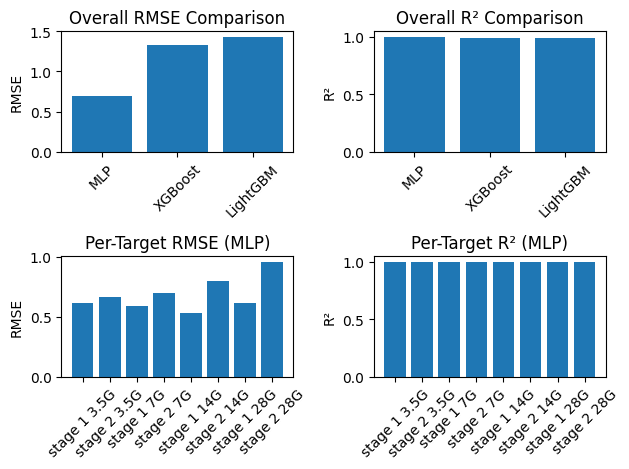

In [59]:
# Plot 1: Overall RMSE comparison
plt.subplot(2, 2, 1)
plt.bar(comparison_df["Model"], comparison_df["Overall_RMSE"])
plt.title("Overall RMSE Comparison")
plt.xticks(rotation=45)
plt.ylabel("RMSE")

# Plot 2: Overall R² comparison
plt.subplot(2, 2, 2)
plt.bar(comparison_df["Model"], comparison_df["Overall_R²"])
plt.title("Overall R² Comparison")
plt.xticks(rotation=45)
plt.ylabel("R²")

# Plot 3: Per-target RMSE for best model
plt.subplot(2, 2, 3)
best_results = all_results[best_model_name]
targets = list(best_results["per_target"].keys())
rmse_values = [best_results["per_target"][t]["RMSE"] for t in targets]
plt.bar(range(len(targets)), rmse_values)
plt.title(f"Per-Target RMSE ({best_model_name})")
plt.xticks(
    range(len(targets)), [t.replace(" attenuation", "") for t in targets], rotation=45
)
plt.ylabel("RMSE")

# Plot 4: Per-target R² for best model
plt.subplot(2, 2, 4)
r2_values = [best_results["per_target"][t]["R²"] for t in targets]
plt.bar(range(len(targets)), r2_values)
plt.title(f"Per-Target R² ({best_model_name})")
plt.xticks(
    range(len(targets)), [t.replace(" attenuation", "") for t in targets], rotation=45
)
plt.ylabel("R²")

plt.tight_layout()
plt.show()

In [60]:
print("\nDetailed Performance Comparison:")
print("=" * 80)
for model_name in comparison_df["Model"]:
    results = all_results[model_name]
    print(f"\n{model_name}:")
    print(f"  Overall RMSE: {results['overall']['RMSE']:.4f}")
    print(f"  Overall MAE:  {results['overall']['MAE']:.4f}")
    print(f"  Overall R²:   {results['overall']['R²']:.4f}")


Detailed Performance Comparison:

MLP:
  Overall RMSE: 0.6954
  Overall MAE:  0.3980
  Overall R²:   0.9986

XGBoost:
  Overall RMSE: 1.3299
  Overall MAE:  0.9096
  Overall R²:   0.9946

LightGBM:
  Overall RMSE: 1.4287
  Overall MAE:  0.9640
  Overall R²:   0.9938


## Improvements

In [ ]:
import shap

# Use the KernelExplainer for your MLP, as it's model-agnostic
# For tree models like XGBoost, use shap.TreeExplainer for much faster performance
explainer = shap.KernelExplainer(
    best_dnn.predict, shap.sample(X_train_df, 50)
)  # Summarize training data
shap_values = explainer.shap_values(X_test_df)

  0%|          | 0/1501 [00:00<?, ?it/s]

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [65]:
# Add this code to your notebook to debug
print(f"Type of shap_values: {type(shap_values)}")

# If it's a list, check the shape of its elements
if isinstance(shap_values, list):
    print(f"Length of shap_values list: {len(shap_values)}")
    print(f"Shape of the first element: {shap_values[0].shape}")
# If it's a numpy array, just check its shape
else:
    print(f"Shape of shap_values array: {shap_values.shape}")

print(f"Shape of X_test_df: {X_test_df.shape}")

Type of shap_values: <class 'numpy.ndarray'>
Shape of shap_values array: (1501, 17, 8)
Shape of X_test_df: (1501, 17)


SHAP Summary Plot for Class 0


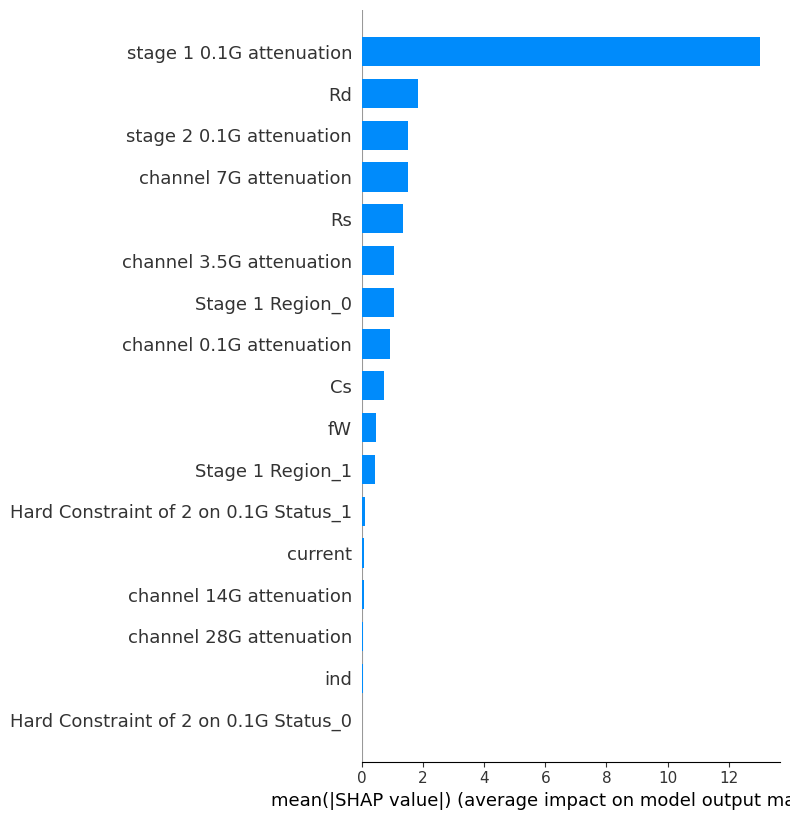

SHAP Summary Plot for Class 1


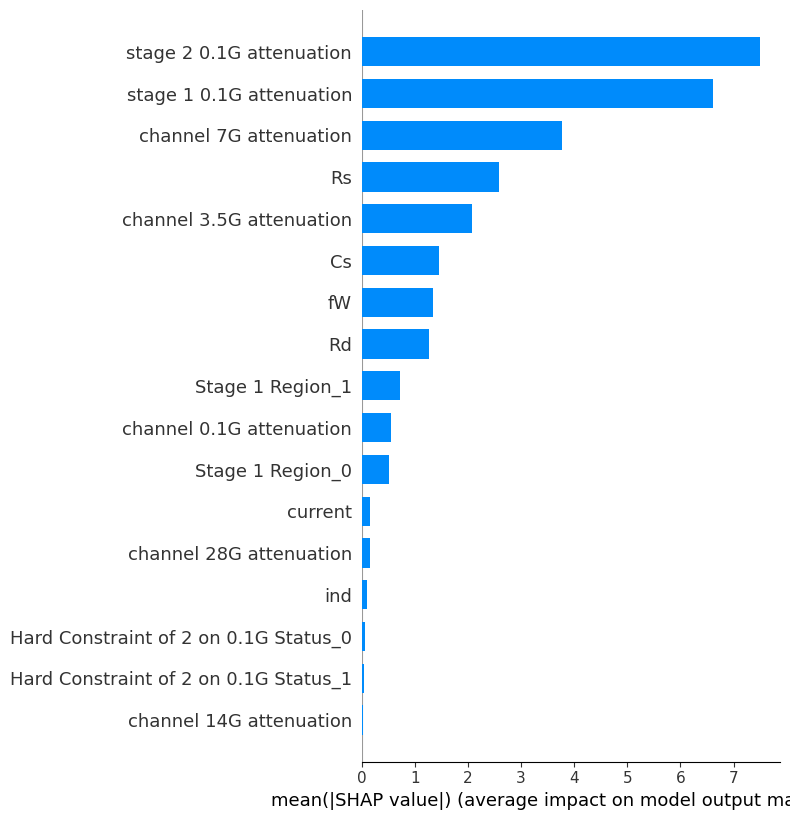

SHAP Summary Plot for Class 2


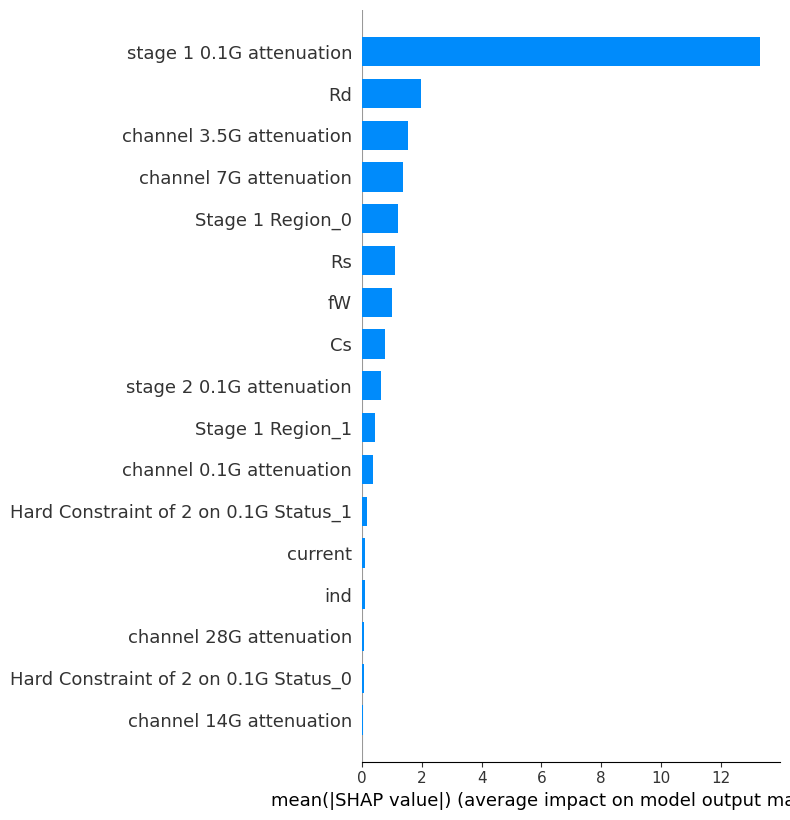

SHAP Summary Plot for Class 3


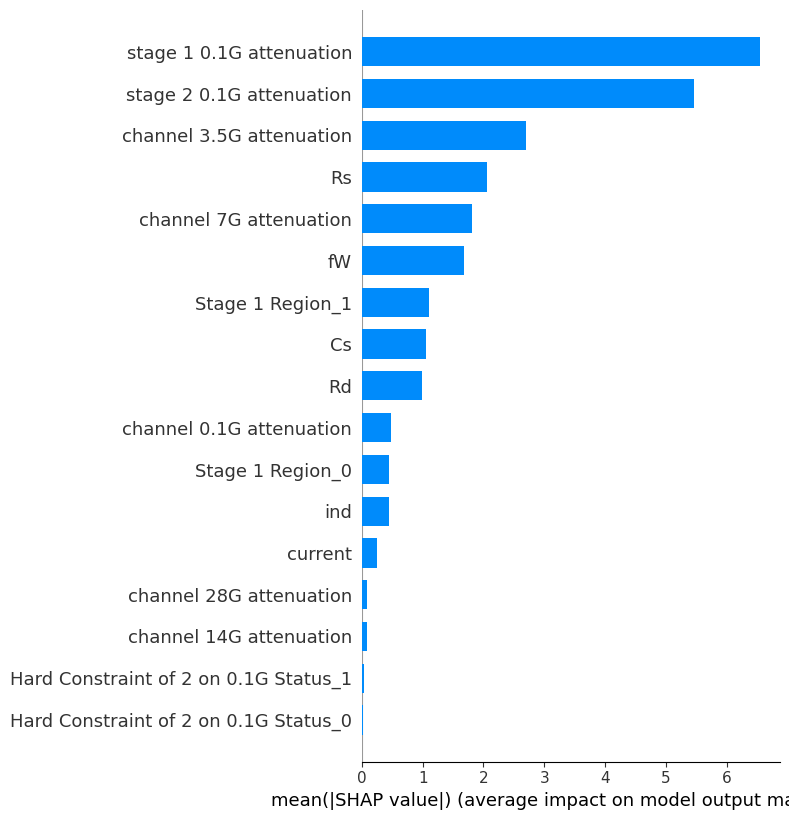

SHAP Summary Plot for Class 4


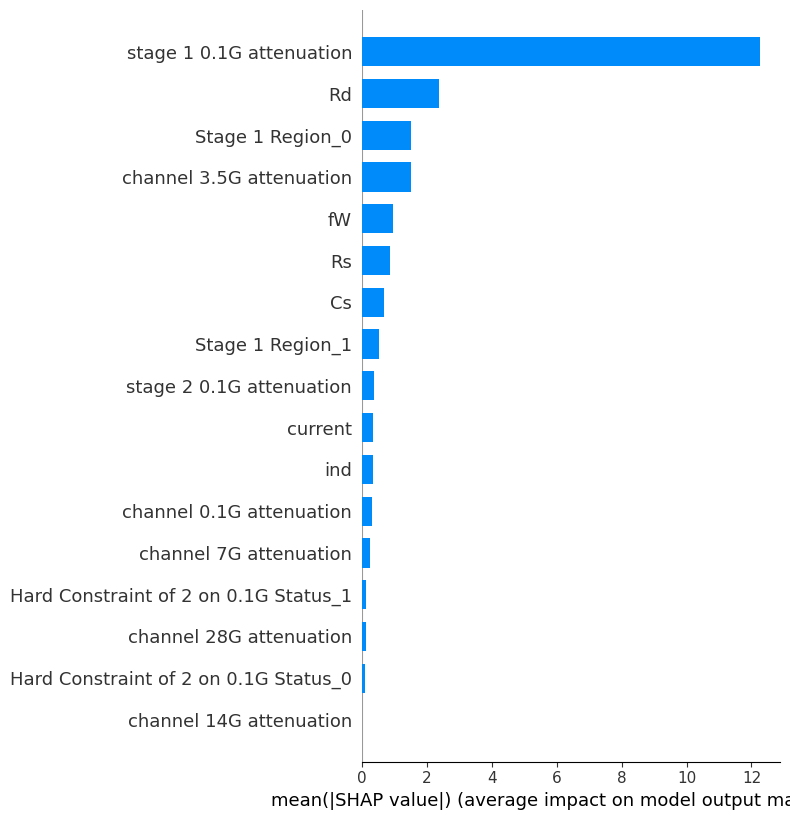

SHAP Summary Plot for Class 5


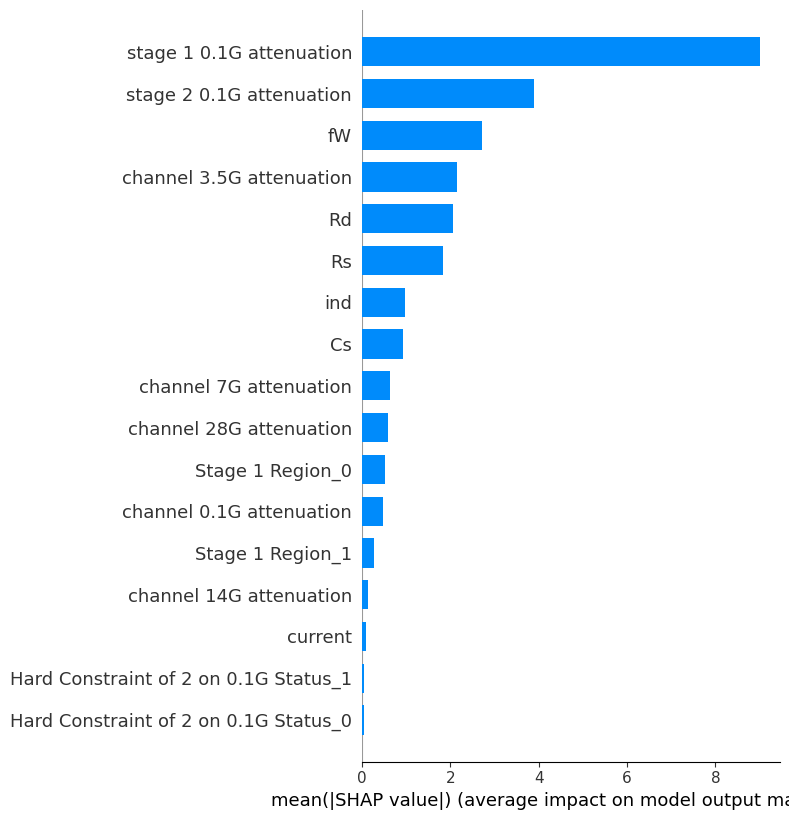

SHAP Summary Plot for Class 6


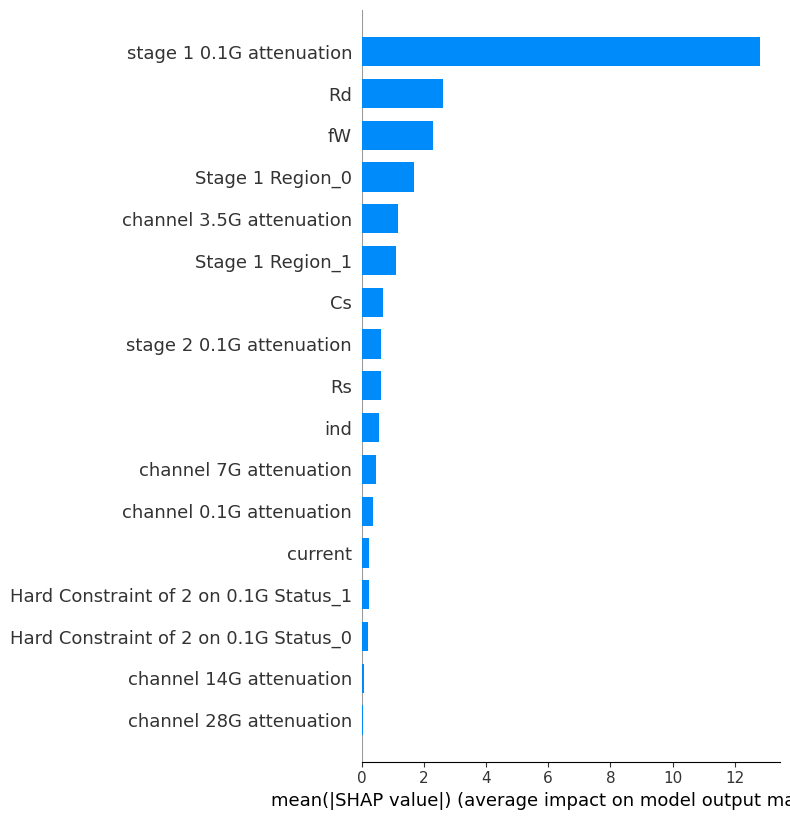

SHAP Summary Plot for Class 7


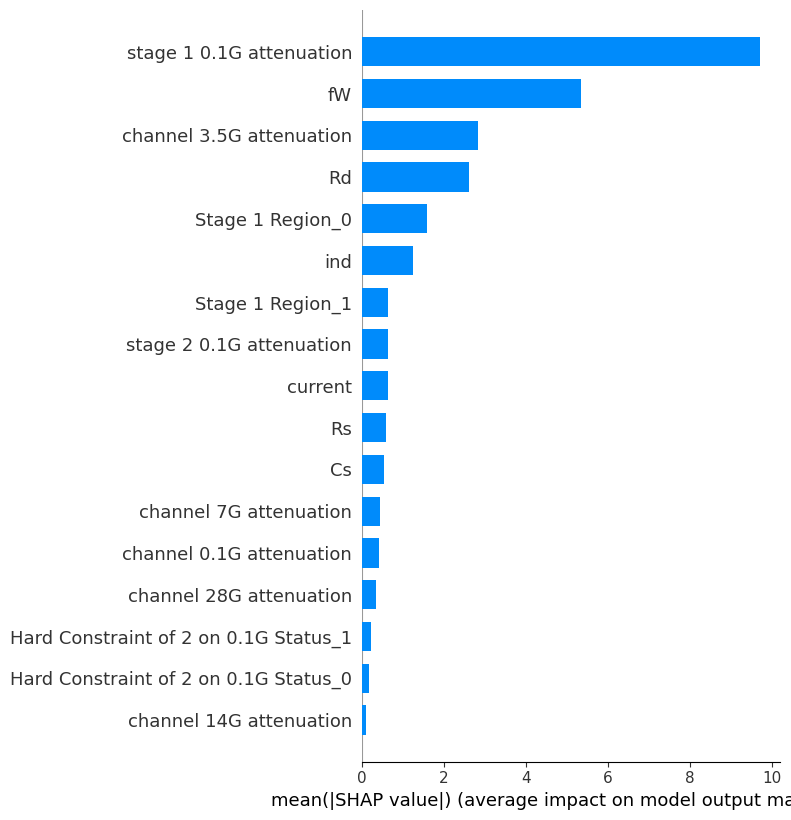

In [68]:
# Loop through all 8 classes and create a summary plot for each
for i in range(8):
    print(f"SHAP Summary Plot for Class {i}")
    shap.summary_plot(shap_values[:, :, i], X_test_df, plot_type="bar", show=True)

## Bayesian Search

In [72]:
# pip install scikit-optimize

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

mlp_search_space = {
    # Let the optimizer choose the number of neurons in each layer
    "estimator__hidden_layer_sizes": Integer(32, 128),
    "estimator__alpha": Real(1e-4, 1e-1, prior="log-uniform"),
    "estimator__learning_rate_init": Real(1e-4, 1e-2, prior="log-uniform"),
}

# Setup the Bayesian Search (rest of the code is the same)
bayes_search = BayesSearchCV(
    estimator=mlp_model,
    search_spaces=mlp_search_space,
    n_iter=32,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)

bayes_search.fit(X_train_df, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

,estimator,MultiOutputRe...dom_state=42))
,search_spaces,"{'estimator__alpha': Real(low=0.00...m='normalize'), 'estimator__hidden_layer_sizes': Integer(low=3...m='normalize'), 'estimator__learning_rate_init': Real(low=0.00...m='normalize')}"
,optimizer_kwargs,None
,n_iter,32
,scoring,'neg_mean_squared_error'
,fit_params,None
,n_jobs,-1
,n_points,1
,iid,'deprecated'
,refit,True
,cv,3


In [ ]:
# Retrieve the best model with the optimal hyperparameters
best_model = bayes_search.best_estimator_

# Use the best model to make predictions on the unseen test data
y_pred = best_model.predict(X_test)

# Calculate the performance metric (e.g., Mean Squared Error)
# Use the same metric family as your 'scoring' parameter for consistency
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Or Root Mean Squared Error for easier interpretation

print(f"Test Set MSE: {mse:.4f}")
print(f"Test Set RMSE: {rmse:.4f}")

In [ ]:
results_df = pd.DataFrame(bayes_search.cv_results_)

# Sort by rank to see the best results at the top
results_df.sort_values(by="rank_test_score", inplace=True)

# Display the top 5 performing hyperparameter sets
print(
    results_df[
        [
            "rank_test_score",
            "mean_test_score",
            "param_estimator__hidden_layer_sizes",
            "param_estimator__alpha",
        ]
    ].head()
)

## Ensemble of DNNs


--- Starting Training for 8 Independent DNNs ---
Training model for: stage 1 3.5G attenuation...
Finished training for stage 1 3.5G attenuation. Final validation loss: 2.2610
Training model for: stage 2 3.5G attenuation...
Finished training for stage 2 3.5G attenuation. Final validation loss: 4.9315
Training model for: stage 1 7G attenuation...
Finished training for stage 1 7G attenuation. Final validation loss: 2.1005
Training model for: stage 2 7G attenuation...
Finished training for stage 2 7G attenuation. Final validation loss: 3.8910
Training model for: stage 1 14G attenuation...
Finished training for stage 1 14G attenuation. Final validation loss: 3.5703
Training model for: stage 2 14G attenuation...
Finished training for stage 2 14G attenuation. Final validation loss: 4.3231
Training model for: stage 1 28G attenuation...
Finished training for stage 1 28G attenuation. Final validation loss: 3.6565
Training model for: stage 2 28G attenuation...
Finished training for stage 2 28G a

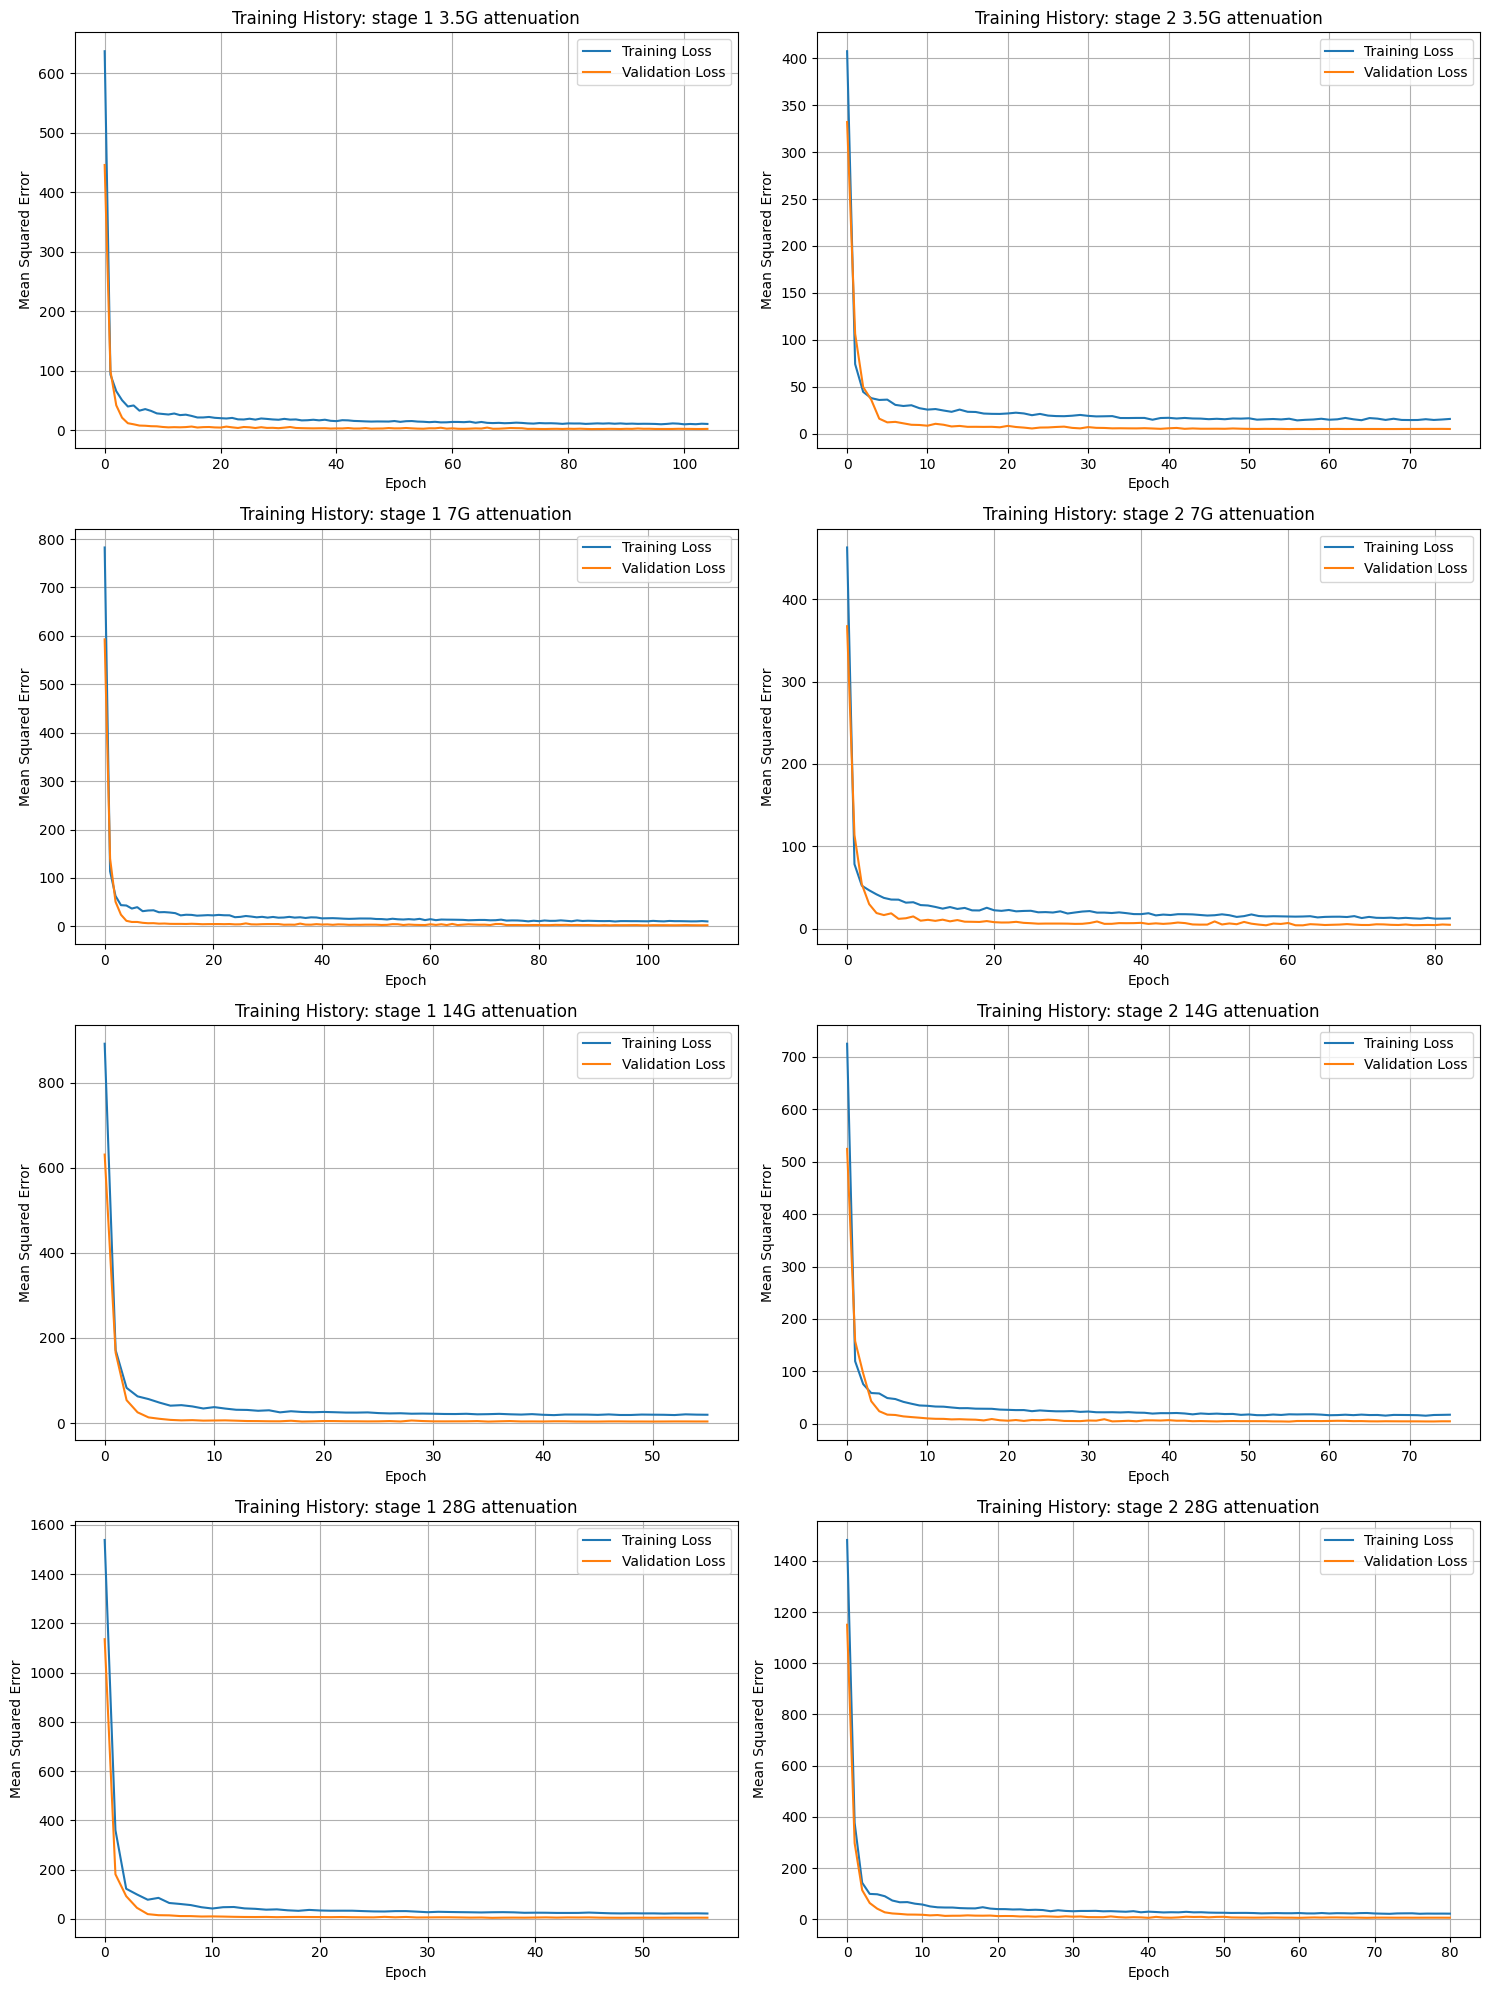

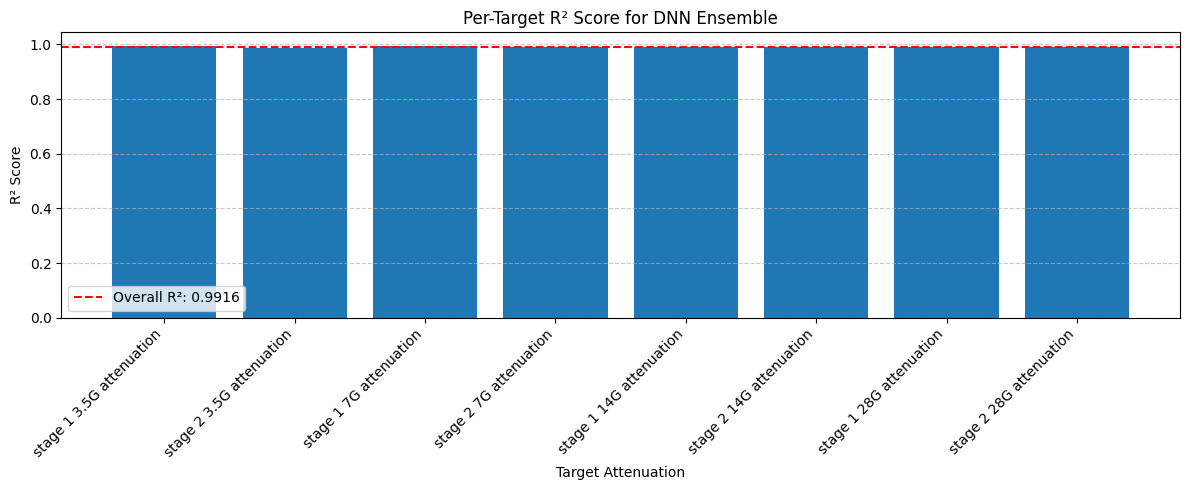

In [71]:
# --- DNN Model Definition ---
def create_dnn_model(input_dim):
    """Creates a compiled Keras Sequential model for single-target regression."""
    model = Sequential(
        [
            Dense(128, activation="relu", input_dim=input_dim),
            BatchNormalization(),
            Dropout(0.3),
            Dense(64, activation="relu"),
            BatchNormalization(),
            Dropout(0.3),
            Dense(32, activation="relu"),
            Dense(1),  # Single output neuron
        ]
    )

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mean_squared_error",
        metrics=["mean_absolute_error"],
    )
    return model


# %%
# --- Training the Ensemble of DNNs ---
trained_models = {}
training_history = {}

# Callbacks for training
early_stopping = EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=10, min_lr=1e-6)

print("\n--- Starting Training for 8 Independent DNNs ---")

for target in target_cols:
    print(f"Training model for: {target}...")

    # Select the single target column for this model
    y_train_target = y_train[target]

    # Create a new KerasRegressor instance for each target
    # This ensures each model is fresh
    input_dimension = X_train_df.shape[1]
    model_for_target = KerasRegressor(
        model=lambda: create_dnn_model(input_dimension),
        epochs=200,
        batch_size=32,
        verbose=0,  # Keep the output clean during the loop
        callbacks=[early_stopping, reduce_lr],
        validation_split=0.15,  # Use a portion of training data for validation
    )

    # Fit the model
    history = model_for_target.fit(X_train_df, y_train_target)

    # Store the trained model and its history
    trained_models[target] = model_for_target
    training_history[target] = history.history_

    print(
        f"Finished training for {target}. Final validation loss: {min(history.history_['val_loss']):.4f}"
    )

print("\n--- All models trained successfully! ---")

# %%
# --- Prediction and Evaluation ---


# Function to evaluate the final ensemble predictions
def evaluate_ensemble(y_true, y_pred_df, model_name="DNN Ensemble"):
    results = {}
    y_pred = y_pred_df.values  # Convert to numpy array for metrics

    # Overall metrics
    results["overall"] = {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R²": r2_score(y_true, y_pred),
    }

    # Per-target metrics
    results["per_target"] = {}
    for i, col in enumerate(y_true.columns):
        results["per_target"][col] = {
            "RMSE": np.sqrt(mean_squared_error(y_true.iloc[:, i], y_pred[:, i])),
            "MAE": mean_absolute_error(y_true.iloc[:, i], y_pred[:, i]),
            "R²": r2_score(y_true.iloc[:, i], y_pred[:, i]),
        }

    # Print results
    print(f"\n{'='*60}\n{model_name} RESULTS\n{'='*60}")
    print(
        f"\nOverall Performance:\n"
        f"RMSE: {results['overall']['RMSE']:.4f}\n"
        f"MAE:  {results['overall']['MAE']:.4f}\n"
        f"R²:   {results['overall']['R²']:.4f}"
    )
    print("\nPer-Target Performance:")
    for target, metrics in results["per_target"].items():
        print(
            f"  {target}:\n"
            f"    RMSE: {metrics['RMSE']:.4f}, MAE: {metrics['MAE']:.4f}, R²: {metrics['R²']:.4f}"
        )

    return results


# Make predictions with each specialized model
predictions = {}
for target, model in trained_models.items():
    print(f"Predicting for: {target}...")
    predictions[target] = model.predict(X_test_df)

# Combine predictions into a single DataFrame
predictions_df = pd.DataFrame(predictions, index=X_test.index)

# Evaluate the final results
ensemble_results = evaluate_ensemble(y_test, predictions_df)

# %%
# --- Visualization ---
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

for i, (target, history) in enumerate(training_history.items()):
    ax = axes[i]
    ax.plot(history["loss"], label="Training Loss")
    ax.plot(history["val_loss"], label="Validation Loss")
    ax.set_title(f"Training History: {target}", fontsize=12)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Mean Squared Error")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# Visualize overall performance
overall_metrics = pd.DataFrame(ensemble_results["overall"], index=[0])
per_target_r2 = {k: v["R²"] for k, v in ensemble_results["per_target"].items()}

plt.figure(figsize=(12, 5))
plt.bar(per_target_r2.keys(), per_target_r2.values())
plt.axhline(
    y=ensemble_results["overall"]["R²"],
    color="r",
    linestyle="--",
    label=f"Overall R²: {ensemble_results['overall']['R²']:.4f}",
)
plt.title("Per-Target R² Score for DNN Ensemble")
plt.xlabel("Target Attenuation")
plt.ylabel("R² Score")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [1]:
# %%
# --- Core Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
import os

# --- Scikit-learn and SciPy Imports ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.optimize import minimize

# --- TensorFlow and Keras Imports ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scikeras.wrappers import KerasRegressor

warnings.filterwarnings("ignore")

# NOTE: This script assumes you have run the 'dnn_ensemble_v1' script first.
# It will check for saved models and train them if they don't exist.


# %%
# --- Custom IQR Outlier Capper (from your original script) ---
class IQROutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_bound_mult=1.5, upper_bound_mult=1.5):
        self.lower_bound_mult = lower_bound_mult
        self.upper_bound_mult = upper_bound_mult
        self.lower_bounds_ = {}
        self.upper_bounds_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        for col in X.columns:
            if pd.api.types.is_numeric_dtype(X[col]) and not X[col].isnull().all():
                Q1 = X[col].quantile(0.25)
                Q3 = X[col].quantile(0.75)
                IQR = Q3 - Q1
                self.lower_bounds_[col] = Q1 - (IQR * self.lower_bound_mult)
                self.upper_bounds_[col] = Q3 + (IQR * self.upper_bound_mult)
        return self

    def transform(self, X):
        X_copy = pd.DataFrame(X).copy()
        for col in X_copy.columns:
            if col in self.lower_bounds_ and pd.api.types.is_numeric_dtype(X_copy[col]):
                X_copy[col] = X_copy[col].clip(
                    lower=self.lower_bounds_[col], upper=self.upper_bounds_[col]
                )
        return X_copy


# %%
# --- Data Loading and Feature/Target Definition ---
file_path = "Data.csv"
df = pd.read_csv(file_path)

target_cols = [
    "stage 1 3.5G attenuation",
    "stage 2 3.5G attenuation",
    "stage 1 7G attenuation",
    "stage 2 7G attenuation",
    "stage 1 14G attenuation",
    "stage 2 14G attenuation",
    "stage 1 28G attenuation",
    "stage 2 28G attenuation",
]
# These are the 6 core features we want to optimize
features_to_optimize = ["fW", "current", "ind", "Rd", "Cs", "Rs"]

# All other features will be held constant at their median value
all_feature_columns = [col for col in df.columns if col not in target_cols]
X = df[all_feature_columns].copy()
y = df[target_cols].copy()

# %%
# --- Preprocessing Pipeline and Model Training (if necessary) ---
MODELS_DIR = "trained_dnn_ensemble"
PREPROCESSOR_FILE = os.path.join(MODELS_DIR, "preprocessor.joblib")
os.makedirs(MODELS_DIR, exist_ok=True)

# Define feature types
numerical_features = [
    "fW",
    "current",
    "ind",
    "Rd",
    "Cs",
    "Rs",
    "channel 0.1G attenuation",
    "channel 3.5G attenuation",
    "channel 7G attenuation",
    "channel 14G attenuation",
    "channel 28G attenuation",
    "stage 1 0.1G attenuation",
    "stage 2 0.1G attenuation",
]
categorical_features = ["Stage 1 Region", "Hard Constraint of 2 on 0.1G Status"]

# Check if models and preprocessor are already saved
if not os.path.exists(PREPROCESSOR_FILE):
    print("--- Preprocessor not found. Training and saving new models. ---")

    # Create and fit the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            (
                "num",
                Pipeline(
                    steps=[
                        ("outlier", IQROutlierCapper()),
                        ("imputer", SimpleImputer(strategy="median")),
                        ("scaler", RobustScaler()),
                    ]
                ),
                numerical_features,
            ),
            (
                "cat",
                Pipeline(
                    steps=[
                        ("imputer", SimpleImputer(strategy="most_frequent")),
                        (
                            "onehot",
                            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
                        ),
                    ]
                ),
                categorical_features,
            ),
        ],
        remainder="drop",
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42
    )
    preprocessor.fit(X_train)
    joblib.dump(preprocessor, PREPROCESSOR_FILE)

    X_train_processed = preprocessor.transform(X_train)

    # Define and train models
    def create_dnn_model(input_dim):
        model = Sequential(
            [
                Dense(128, activation="relu", input_dim=input_dim),
                BatchNormalization(),
                Dropout(0.3),
                Dense(64, activation="relu"),
                BatchNormalization(),
                Dropout(0.3),
                Dense(32, activation="relu"),
                Dense(1),
            ]
        )
        model.compile(optimizer=Adam(0.001), loss="mean_squared_error")
        return model

    for target in target_cols:
        print(f"Training and saving model for: {target}...")
        y_train_target = y_train[target]
        model = KerasRegressor(
            model=lambda: create_dnn_model(X_train_processed.shape[1]),
            epochs=200,
            batch_size=32,
            verbose=0,
            callbacks=[
                EarlyStopping(patience=20, restore_best_weights=True),
                ReduceLROnPlateau(patience=10),
            ],
        )
        model.fit(X_train_processed, y_train_target, validation_split=0.15)
        model.model_.save(os.path.join(MODELS_DIR, f"model_{target}.keras"))
else:
    print("--- Found existing models. Loading them. ---")
    preprocessor = joblib.load(PREPROCESSOR_FILE)

# Load all trained models
trained_models = {}
for target in target_cols:
    model_path = os.path.join(MODELS_DIR, f"model_{target}.keras")
    trained_models[target] = tf.keras.models.load_model(model_path)

print("\n--- System Ready for Optimization ---")

# %%
# --- Optimization Setup ---

# 1. Define bounds for the features we want to optimize.
# This is CRITICAL to ensure the optimizer suggests realistic values.
bounds = {feat: (df[feat].min(), df[feat].max()) for feat in features_to_optimize}
print("\nOptimization Bounds (min, max):")
for f, b in bounds.items():
    print(f"  {f}: ({b[0]:.2e}, {b[1]:.2e})")


# 2. Define the objective function for the optimizer.
def objective_function(x, target_attenuations, constant_features):
    """
    Calculates the error between model predictions and target attenuations.

    Args:
        x (np.array): A numpy array of the 6 feature values being optimized.
        target_attenuations (np.array): The desired output values.
        constant_features (pd.DataFrame): A DataFrame with the other 9 features held constant.

    Returns:
        float: The mean squared error.
    """
    # Create a full feature DataFrame from the optimizer's guess and constants
    guess_df = constant_features.copy()
    for i, feat in enumerate(features_to_optimize):
        guess_df[feat] = x[i]

    # Preprocess the complete feature set
    processed_guess = preprocessor.transform(guess_df)

    # Predict with the ensemble
    predictions = []
    for target in target_cols:
        pred = trained_models[target].predict(processed_guess, verbose=0)
        predictions.append(pred[0][0])

    # Calculate and return the error
    error = np.mean((np.array(predictions) - target_attenuations) ** 2)
    return error


# %%
# --- Run the Inverse Design Optimization ---

# Define your desired target attenuation profile
desired_targets = np.array(
    [
        -25.0,
        -20.0,  # 3.5G stage 1 & 2
        -30.0,
        -25.0,  # 7G stage 1 & 2
        -35.0,
        -30.0,  # 14G stage 1 & 2
        -40.0,
        -40.0,  # 28G stage 1 & 2
    ]
)

# Set the values for the features we are NOT optimizing (held constant)
# We use the median of the original dataset as a reasonable default.
constant_features_df = pd.DataFrame([X.median()], columns=all_feature_columns)

# Get initial guess and bounds in the format scipy needs
initial_guess = [constant_features_df[feat].iloc[0] for feat in features_to_optimize]
scipy_bounds = [bounds[feat] for feat in features_to_optimize]

print("\n--- Starting Optimization ---")
print(f"Desired Targets: {desired_targets}")

# Run the optimizer!
result = minimize(
    fun=objective_function,
    x0=initial_guess,
    args=(desired_targets, constant_features_df),
    method="L-BFGS-B",  # A good method that respects bounds
    bounds=scipy_bounds,
    options={"disp": True, "maxiter": 200},
)

print("\n--- Optimization Complete ---")

# %%
# --- Display Results ---
if result.success:
    optimal_inputs = result.x
    final_error = result.fun

    print("\nSuccessfully found an optimal input set!")
    print(f"Final Mean Squared Error: {final_error:.6f}")

    print("\nOptimal Input Feature Values:")
    optimal_df = pd.DataFrame([optimal_inputs], columns=features_to_optimize)
    print(optimal_df.to_string(index=False, float_format="%.4e"))

    # Verify the result by predicting with the optimal inputs
    final_guess_df = constant_features_df.copy()
    for i, feat in enumerate(features_to_optimize):
        final_guess_df[feat] = optimal_inputs[i]

    final_processed_guess = preprocessor.transform(final_guess_df)

    final_predictions = []
    for target in target_cols:
        pred = trained_models[target].predict(final_processed_guess, verbose=0)
        final_predictions.append(pred[0][0])

    results_comparison = pd.DataFrame(
        {
            "Target Name": target_cols,
            "Desired Value": desired_targets,
            "Predicted Value (from Optimal Inputs)": final_predictions,
        }
    )
    print("\nComparison of Desired vs. Achieved Targets:")
    print(results_comparison.to_string(index=False))

else:
    print("\nOptimization failed or did not converge.")
    print(result.message)

--- Preprocessor not found. Training and saving new models. ---
Training and saving model for: stage 1 3.5G attenuation...
Training and saving model for: stage 2 3.5G attenuation...
Training and saving model for: stage 1 7G attenuation...
Training and saving model for: stage 2 7G attenuation...
Training and saving model for: stage 1 14G attenuation...
Training and saving model for: stage 2 14G attenuation...
Training and saving model for: stage 1 28G attenuation...
Training and saving model for: stage 2 28G attenuation...

--- System Ready for Optimization ---

Optimization Bounds (min, max):
  fW: (1.00e-06, 1.00e-05)
  current: (5.00e-04, 2.50e-03)
  ind: (4.01e-15, 3.00e-09)
  Rd: (1.08e+01, 1.50e+03)
  Cs: (1.21e-15, 1.00e-12)
  Rs: (1.03e+01, 1.50e+03)

--- Starting Optimization ---
Desired Targets: [-25. -20. -30. -25. -35. -30. -40. -40.]

--- Optimization Complete ---

Successfully found an optimal input set!
Final Mean Squared Error: 1.967394

Optimal Input Feature Values:
   